https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [20]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
'''
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D
from keras.models import Model
from keras.datasets import fashion_mnist,mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [5]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [7]:
x_train.shape

(60000, 784)

In [8]:
original_dim

784

In [9]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [10]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) ## two inputs to one output?

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [11]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [12]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [13]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [14]:
# vae.load_weights('vae_mnist.h5') # load all the weights for encoder and decoder when loading for vae

In [15]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 68us/step - loss: 45.6423 - val_loss: 36.0508
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 34.3205 - val_loss: 33.0664
Epoch 3/50
60000/60000 [==============================] - 2s 28us/step - loss: 32.8520 - val_loss: 32.3264
Epoch 4/50
60000/60000 [=====

[[ 0.288033  -0.7312888]]
[[1.99543   0.6016038]]


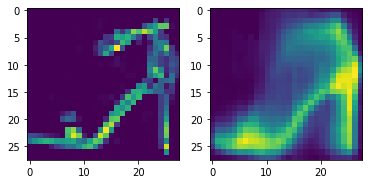

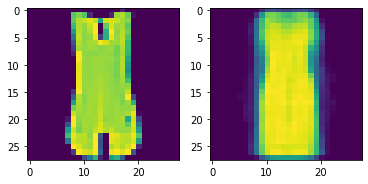

In [16]:
original_1 = x_train[8]
encoded_z_1 = encoder.predict(np.expand_dims(original_1,0),batch_size=1)[2]
print(encoded_z_1)
predict = decoder.predict(encoded_z_1)
original_digit_1 = original_1.reshape(image_size,image_size)
decoded_digit_1 = predict.reshape(image_size, image_size)
fig, axes = plt.subplots(1,2)
axes[0].imshow(original_digit_1)
axes[1].imshow(decoded_digit_1)

original_2 = x_train[4]
encoded_z_2 = encoder.predict(np.expand_dims(original_2,0),batch_size=1)[2]
print(encoded_z_2)
predict = decoder.predict(encoded_z_2)
original_digit_2 = original_2.reshape(image_size,image_size)
decoded_digit_2 = predict.reshape(image_size, image_size)
fig, axes = plt.subplots(1,2)
axes[0].imshow(original_digit_2)
axes[1].imshow(decoded_digit_2)

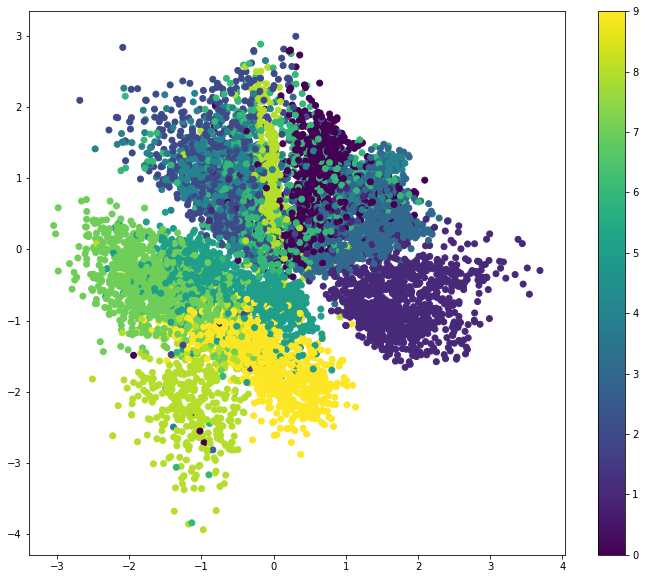

In [17]:
x_test_encoded = encoder.predict(x_test, batch_size=1)[2]

plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

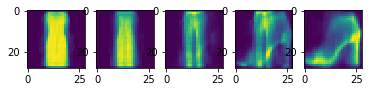

In [18]:
center_z = (encoded_z_1+encoded_z_2)/2
toward_1_z = (encoded_z_1+center_z)/2
toward_1_1_z = (encoded_z_1+toward_1_z)/2
# print(center_z)
# print(toward_1_z)
predict_center = decoder.predict(center_z)
predict_toward_1 = decoder.predict(toward_1_z)
predict_toward_1_1 = decoder.predict(toward_1_1_z)

decoded_digit_new_center = predict_center.reshape(image_size, image_size)
decoded_digit_new_toward_1 = predict_toward_1.reshape(image_size, image_size)
decoded_digit_new_toward_1_1 = predict_toward_1_1.reshape(image_size, image_size)

fig, axes = plt.subplots(1,5)
axes[0].imshow(decoded_digit_2)
axes[1].imshow(decoded_digit_new_center)
axes[2].imshow(decoded_digit_new_toward_1)
axes[3].imshow(decoded_digit_new_toward_1_1)
axes[4].imshow(decoded_digit_1)


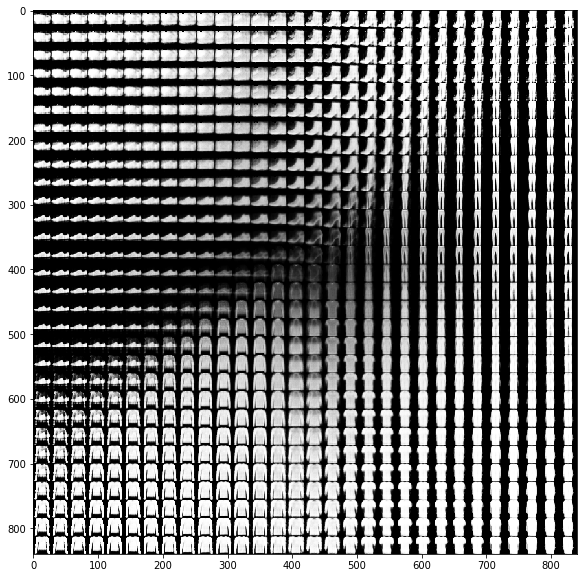

In [19]:
# display a 2D manifold of the digits
n = 30  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show()